# ARIMA Presentation Prep

#### Buildings that have failed:
- 603
- 604
- 618

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
import pickle
import math

pd.set_option('display.max_columns', None)

In [2]:
%matplotlib inline

import sys
import statsmodels as ss
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

In [358]:
with open('berkeley_clean4.pkl','rb') as read_file:
    berkeley_df = pickle.load(read_file)

In [359]:
with open('berkeley_building_info.pkl','rb') as read_file:
    building_data = pickle.load(read_file)

### Clean Up Building Data
- Insert missing addresses
- Delete unwanted columns
- Create latitude, longitude columns for Tableau
- etc.

In [360]:
building_list = sorted(list(set(berkeley_df['building_id'].values)))

In [361]:
building_data

,berkeley_id,square_feet,year,name,spaceUse,address,timezone,resources,ashrae_id,mae
0,173,252597,1984,Recreational Sports Facility,Other,"37.868448, -122.262184",America/Los_Angeles,"[Electricity, Outside]",NaN,NaN
1,174,43599,1998,Silver Space Sciences Laboratory Addition,Laboratory,"37.880843, -122.243914",America/Los_Angeles,"[Electricity, Outside]",NaN,NaN
2,175,54000,2015,Maxwell Family Field,CollegeUniversity,"Berkeley, California",America/Los_Angeles,"[Electricity, Outside]",NaN,NaN
3,176,110565,1994,Soda Hall,Laboratory,"37.875511, -122.258656",America/Los_Angeles,"[Steam, Electricity, Outside]",641.0,4.042443
4,177,111198,1941,Sproul Hall,Administrative,"37.869734, -122.258924",America/Los_Angeles,"[Electricity, Outside]",643.0,1.579731
...,...,...,...,...,...,...,...,...,...,...
117,291,91594,-1,Northwest Parking Garage,VehicleStorage,"37.873696, -122.265848",America/Los_Angeles,"[Electricity, Outside]",633.0,0.001653
118,292,10535,1960,Oxford Tract,Laboratory,"37.875274, -122.267085",America/Los_Angeles,"[Electricity, Outside]",NaN,NaN
119,3727,80000,2018,Chou Hall,Unspecified,"Berkeley, California",America/Los_Angeles,"[NaturalGas, Electricity, Outside]",NaN,NaN
120,5824,230000,2019,Berkeley Way West,CollegeUniversity,"Berkeley, California",America/Los_Angeles,"[Electricity, Outside]",NaN,NaN


In [362]:
building_data_rel = building_data.dropna()

In [363]:
building_data_rel.sort_values(by='ashrae_id', inplace=True)

/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [364]:
del building_data_rel['timezone']
del building_data_rel['berkeley_id']
del building_data_rel['mae']

In [365]:
building_data_rel = building_data_rel[['ashrae_id', 'name', 'address', 'spaceUse', 'year', 'square_feet', 'resources']]


In [366]:
building_data_list = np.array(building_data_rel['ashrae_id'].values)

In [367]:
np.setdiff1d(building_data_list, building_list,assume_unique=False)

array([566., 579., 591., 596., 613., 639., 650.])

In [368]:
building_data_rel = building_data_rel.set_index('ashrae_id', drop=True)

In [369]:
building_data_rel = building_data_rel.drop([566,579,591,596,613,639,650])

In [370]:
latitude = []
longitude = []

for address in building_data_rel['address'].values:
    if address[:3] == '37.':
        address = address.split(',')
        latitude.append(address[0])
        longitude.append(address[1])
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)        

In [371]:
len(latitude)

74

In [372]:
building_data_rel.insert(2, column = 'latitude', value = latitude)
building_data_rel.insert(3, column = 'longitude', value = longitude)

In [373]:
building_data_rel.loc[[567],['address']] = '2155 Center St, Berkeley, CA 94720'
building_data_rel.loc[[607],['address']] = '2545 Bancroft Way, Berkeley, CA 94704'
building_data_rel.loc[[621],['address']] = '2175 Gayley Rd, Berkeley, CA 94720'

In [374]:
building_data_rel.loc[[574],['address']] = 'Sather Rd, Berkeley, CA 94709'
building_data_rel.loc[[570],['address']] = 'Berkeley, CA 94720'
building_data_rel.loc[[571],['address']] = 'Berkeley, CA 94709'


In [375]:
building_data_rel

,name,address,latitude,longitude,spaceUse,year,square_feet,resources
ashrae_id,,,,,,,,
565.0,Alumni House,"37.869675, -122.261103",37.869675,-122.261103,CollegeUniversity,1954,15590,"[Electricity, Outside]"
567.0,BAMPFA,"2155 Center St, Berkeley, CA 94720",NaN,NaN,CollegeUniversity,2016,83000,"[Electricity, Outside]"
568.0,2200 Bancroft Way,2200 Bancroft Way,NaN,NaN,Unspecified,-1,14468,"[Electricity, Outside]"
569.0,Barker Hall,"37°52'26.1""N 122°15'55.7""W",NaN,NaN,Laboratory,1964,88161,"[Electricity, Outside]"
570.0,Barrows Hall,"Berkeley, CA 94720",NaN,NaN,Administrative,1964,198294,"[Electricity, Outside]"
...,...,...,...,...,...,...,...,...
649.0,Tan Hall,"37.873139, -122.256468",37.873139,-122.256468,Laboratory,1996,118376,"[Electricity, Outside]"
652.0,University Hall,"37.872023, -122.266386",37.872023,-122.266386,Administrative,1959,152987,"[Condensate, Water, Electricity, Outside]"
653.0,Valley Life Sciences Building,"37.871634, -122.262168",37.871634,-122.262168,Laboratory,1930,421939,"[Electricity, Outside]"


In [376]:
# building_data_rel.to_csv(r'Building_Data_Scratch.csv')

### Updated version of building data (includes missing latitude, longitude values)

In [377]:
# Read in updated version

building_data_updated = pd.read_csv('Building_Data.csv')

In [378]:
building_data_updated

,ashrae_id,name,address,latitude,longitude,spaceUse,year,square_feet,resources
0,632,O'Brien Hall,"37.874355, -122.259059",37.874355,-122.259059,Administrative,1959,41822,"['Electricity', 'Outside']"
1,568,2200 Bancroft Way,2200 Bancroft Way,37.867793,-122.265697,Administrative,-1,14468,"['Electricity', 'Outside']"
2,635,2224 Piedmont Ave,"2224 Piedmont Ave, Berkeley California",37.871030,-122.252820,Administrative,-1,7271,"['Electricity', 'Outside']"
3,636,2232 Piedmont Ave,"2232 Piedmont Ave, Berkeley",37.870780,-122.253040,Administrative,-1,6706,"['Electricity', 'Outside']"
4,637,2234 Piedmont Ave,"2234 Piedmont Ave, Berkeley",37.870940,-122.252810,Administrative,-1,4281,"['Electricity', 'Outside']"
...,...,...,...,...,...,...,...,...,...
69,604,2537 Haste Street,2537 Haste Street,37.866150,-122.257930,Student Services,-1,6500,"['Electricity', 'Outside']"
70,565,Alumni House,"37.869675, -122.261103",37.869675,-122.261103,Student Services,1954,15590,"['Electricity', 'Outside']"
71,580,Cesar Chavez Student Center,"37.869754, -122.259815",37.869754,-122.259815,Student Services,1960,110959,"['Electricity', 'Outside']"
72,621,Maxwell Garage,"2175 Gayley Rd, Berkeley, CA 94720",37.872400,-122.252900,Vehicle Storage,2015,104000,"['Electricity', 'Outside']"


In [379]:
building_data_updated['spaceUse'].value_counts()

Laboratory          28
Administrative      22
Library              6
Education            5
Recreation           4
Student Services     3
Gymnasium            2
Vehicle Storage      2
Museum               1
Dormitory            1
Name: spaceUse, dtype: int64

## Group by Building Use

In [380]:
building_df = pd.read_csv('ashrae-energy-prediction/building_metadata.csv')

In [678]:
# berkeley_buildings_df.info()

In [679]:
# berkeley_buildings_group_df = berkeley_buildings_df.groupby(['building_id', 'primary_use', 'square_feet', 'year_built', 'floor_count']).agg({'meter_reading_scraped':'sum'}).reset_index()


In [680]:
# berkeley_buildings_group_df.primary_use.value_counts()

In [681]:
# buildings_use_df = berkeley_buildings_df.groupby(['primary_use', 'Date']).agg({'meter_reading_scraped':'sum'}).reset_index()
# buildings_use_df

In [682]:
# education_buildings_df = buildings_use_df[buildings_use_df['primary_use'] == 'Education']
# entertainment_buildings_df = buildings_use_df[buildings_use_df['primary_use'] == 'Entertainment/public assembly']
# public_buildings_df = buildings_use_df[buildings_use_df['primary_use'] == 'Public services']
# parking_buildings_df = buildings_use_df[buildings_use_df['primary_use'] == 'Parking']
# tech_buildings_df = buildings_use_df[buildings_use_df['primary_use'] == 'Technology/science']
# residential_buildings_df = buildings_use_df[buildings_use_df['primary_use'] == 'Lodging/residential']
# utility_buildings_df = buildings_use_df[buildings_use_df['primary_use'] == 'Utility']


## Group by Date, Split by Building

In [381]:
berkeley_date = berkeley_df.groupby(['Date', 'Year', 'building_id']).agg({'meter_reading_scraped':'sum'}).reset_index()

In [382]:
berkeley_date = berkeley_date.sort_values(by=['building_id','Date']).reset_index(drop=True)

In [383]:
# berkeley_date = berkeley_date.set_index('Date')

In [384]:
berkeley_date

,Date,Year,building_id,meter_reading_scraped
0,2016-01-01,2016,565,186.0
1,2016-01-02,2016,565,189.0
2,2016-01-03,2016,565,232.0
3,2016-01-04,2016,565,298.0
4,2016-01-05,2016,565,309.0
...,...,...,...,...
105815,2019-11-26,2019,655,3359.0
105816,2019-11-27,2019,655,3031.0
105817,2019-11-28,2019,655,2900.0
105818,2019-11-29,2019,655,3314.0


In [385]:
building_list = berkeley_date['building_id'].unique()

In [386]:
building_list

array([565, 567, 568, 569, 570, 571, 573, 574, 575, 576, 577, 580, 582,
       583, 584, 585, 586, 587, 588, 589, 592, 594, 595, 597, 598, 599,
       600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,
       614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 626, 627,
       628, 630, 631, 632, 633, 634, 635, 636, 637, 638, 640, 641, 642,
       643, 644, 645, 646, 649, 652, 653, 654, 655])

In [387]:
# Split dataframe by the 74 buidlings.

def building_df_separator(full_df, building_no):
    
    building_df = full_df[full_df['building_id'] == building_no]
        
    return building_df

In [388]:
berkeley_date_dict = {}

for i in building_list:
    berkeley_date_dict[i] = building_df_separator(berkeley_date, i)

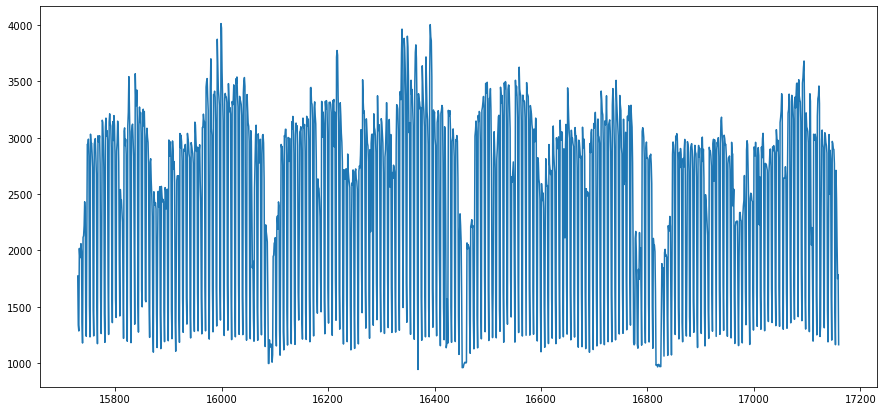

In [389]:
plt.figure(figsize=(15,7))
plt.plot(berkeley_date_dict[580].index, berkeley_date_dict[580]['meter_reading_scraped'])

## Read in Predictions

In [390]:
building_list

array([565, 567, 568, 569, 570, 571, 573, 574, 575, 576, 577, 580, 582,
       583, 584, 585, 586, 587, 588, 589, 592, 594, 595, 597, 598, 599,
       600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,
       614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 626, 627,
       628, 630, 631, 632, 633, 634, 635, 636, 637, 638, 640, 641, 642,
       643, 644, 645, 646, 649, 652, 653, 654, 655])

In [391]:
with open('sar_pred_dict_month.pkl', 'rb') as read_file:
    sar_pred_dict = pickle.load(read_file)

In [392]:
with open('mae_dict_month.pkl', 'rb') as read_file:
    mae_dict = pickle.load(read_file)

In [393]:
with open('sar_pred_dict_month_R1.pkl', 'rb') as read_file:
    unordered_sar_pred_dict1 = pickle.load(read_file)

In [394]:
with open('mae_dict_month_R1.pkl', 'rb') as read_file:
    unordered_mae_dict1 = pickle.load(read_file)

In [395]:
sar_pred_dict.keys()
sar_pred_dict_keys = list(sar_pred_dict.keys())
sar_pred_dict_keys[1]

567

In [396]:
import collections
mae_dict1 = collections.OrderedDict(sorted(unordered_mae_dict1.items()))
sar_pred_dict1 = collections.OrderedDict(sorted(unordered_sar_pred_dict1.items()))

In [397]:
mae_df = pd.DataFrame(mae_dict.values(), index = mae_dict.keys(), columns = ['R1'])

In [398]:
mae_df['R2'] = mae_dict1.values()

In [399]:
mae_df.head(50)

,R1,R2
565,12.585273,8.025521
567,5.488550,5.898290
568,11.000392,8.529155
569,8.022971,13.580448
570,5.581260,3.031337
571,22.834258,10.861187
573,8.430142,6.566675
574,16.864405,7.466401
575,7.968368,7.544067
576,7.084708,14.101136


In [400]:
mae_df = mae_df.reset_index()

In [401]:
mae_df.rename(columns={'index':'building_id'}, inplace=True)

In [402]:
mae_df.loc[mae_df.building_id == 632, 'R2'] = 100

In [442]:
mae_df.tail(50)

,building_id,R1,R2,R3
21,594,2.639648,3.061478,2.639648
22,595,5.706031,4.171173,4.171173
23,597,9.708633,13.627591,9.708633
24,598,0.294012,1.274447,0.294012
25,599,18.700489,17.971451,17.971451
26,600,6.281194,6.784871,6.281194
27,601,46.151559,90.257906,46.151559
28,602,9.983520,14.864830,9.983520
29,605,17.620232,9.547970,9.547970
30,606,3.187226,3.880879,3.187226


In [404]:
# mae_df_list = []

# for index, rows in mae_df.iterrows():
#         mae_df_list.append((rows['R1'], rows['R2']))

In [405]:
# key_list = list(mae_dict.keys())

In [406]:
# min_mae_dict = {}

# for index, key in enumerate(key_list):
#     min_mae_dict[key] = min(mae_df_list[index])

In [407]:
sar_pred_dict_final = {}
mae_dict_final = {}

for index, rows in mae_df.iterrows():
    b_id = rows['building_id']
    if rows['R1'] < rows['R2']:
        sar_pred_dict_final[b_id] = sar_pred_dict[b_id]
        mae_dict_final[b_id] = mae_dict[b_id]
    elif rows['R1'] > rows['R2']:
        sar_pred_dict_final[b_id] = sar_pred_dict1[b_id]
        mae_dict_final[b_id] = mae_dict1[b_id]

In [408]:
mae_df['R3'] = mae_dict_final.values()

In [409]:
mae_df.head(50)

,building_id,R1,R2,R3
0,565,12.585273,8.025521,8.025521
1,567,5.488550,5.898290,5.488550
2,568,11.000392,8.529155,8.529155
3,569,8.022971,13.580448,8.022971
4,570,5.581260,3.031337,3.031337
5,571,22.834258,10.861187,10.861187
6,573,8.430142,6.566675,6.566675
7,574,16.864405,7.466401,7.466401
8,575,7.968368,7.544067,7.544067
9,576,7.084708,14.101136,7.084708


(array([25., 28., 11.,  3.,  1.,  0.,  1.,  1.,  0.,  1.]),
 array([ 0.29401195,  4.87976669,  9.46552143, 14.05127617, 18.63703092,
        23.22278566, 27.8085404 , 32.39429514, 36.98004988, 41.56580463,
        46.15155937]),
 <a list of 10 Patch objects>)

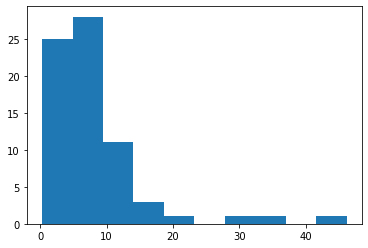

In [410]:
plt.hist(mae_dict_final.values())

## Export Data to CSV

#### Merge Building Names with Meter Reading dataframe

In [411]:
building_data_updated = building_data_updated.sort_values(by='ashrae_id')
building_names = building_data_updated[['ashrae_id', 'name']]

In [412]:
building_names.rename(columns={'ashrae_id':'building_id'}, inplace=True)

In [413]:
building_names.tail(50)

,building_id,name
12,598,Giannini Hall
13,599,Giauque Hall
39,600,Gilman Hall
67,601,Greek Theater
68,602,Haas Pavilion
62,603,Hargrove Music Library
69,604,2537 Haste Street
14,605,Haviland Hall
40,606,Hazardous Material Facility
21,607,Hearst Field Annex


In [414]:
berkeley_date = berkeley_date.merge(building_names, how='left', on='building_id')

In [415]:
building_date_key = []

for index, rows in berkeley_date.iterrows():
    key = str(str(rows['building_id']) + '_' + str(rows['Date']))
    building_date_key.append(key)

In [416]:
berkeley_date

,Date,Year,building_id,meter_reading_scraped,name
0,2016-01-01,2016,565,186.0,Alumni House
1,2016-01-02,2016,565,189.0,Alumni House
2,2016-01-03,2016,565,232.0,Alumni House
3,2016-01-04,2016,565,298.0,Alumni House
4,2016-01-05,2016,565,309.0,Alumni House
...,...,...,...,...,...
105815,2019-11-26,2019,655,3359.0,Zellerbach Hall
105816,2019-11-27,2019,655,3031.0,Zellerbach Hall
105817,2019-11-28,2019,655,2900.0,Zellerbach Hall
105818,2019-11-29,2019,655,3314.0,Zellerbach Hall


In [417]:
berkeley_date.insert(3, column = 'Year_Building_Key', value = building_date_key)

In [418]:
berkeley_date

,Date,Year,building_id,Year_Building_Key,meter_reading_scraped,name
0,2016-01-01,2016,565,565_2016-01-01,186.0,Alumni House
1,2016-01-02,2016,565,565_2016-01-02,189.0,Alumni House
2,2016-01-03,2016,565,565_2016-01-03,232.0,Alumni House
3,2016-01-04,2016,565,565_2016-01-04,298.0,Alumni House
4,2016-01-05,2016,565,565_2016-01-05,309.0,Alumni House
...,...,...,...,...,...,...
105815,2019-11-26,2019,655,655_2019-11-26,3359.0,Zellerbach Hall
105816,2019-11-27,2019,655,655_2019-11-27,3031.0,Zellerbach Hall
105817,2019-11-28,2019,655,655_2019-11-28,2900.0,Zellerbach Hall
105818,2019-11-29,2019,655,655_2019-11-29,3314.0,Zellerbach Hall


#### Create Single Meter Predictions dataframe to merge with Actual Meter Readings dataframe

In [419]:
sar_pred_df = pd.DataFrame(sar_pred_dict_final[565], columns = ['meter_reading_predictions'])

In [420]:
key_565 = ['565']*28

In [421]:
sar_pred_df.insert(0, column='building_id', value= key_565)

In [422]:
sar_pred_df

,building_id,meter_reading_predictions
2019-11-01,565,309.656306
2019-11-02,565,243.660896
2019-11-03,565,241.133169
2019-11-04,565,316.424302
2019-11-05,565,318.190946
2019-11-06,565,316.674300
2019-11-07,565,312.645489
2019-11-08,565,304.137472
2019-11-09,565,240.881747
2019-11-10,565,239.729018


In [709]:
# sar_pred_df = sar_pred_df.reset_index()

In [710]:
# sar_pred_df.rename(columns={'index': 'Date'}, inplace=True)

In [712]:
# prediction_date_key = []

# for index, rows in sar_pred_df.iterrows():
#     key = str(str(rows['building_id']) + '_' + str(rows['Year']))
#     prediction_date_key.append(key)

In [713]:
# sar_pred_df.insert(2, column='Year_Building_Key', value= prediction_date_key)

In [714]:
# prediction_date_key = []

# for index, values in sar_pred_df['Year_Building_Key'].iteritems():
#     values = values.split(' ')
#     prediction_date_key.append(values[0])
    
# sar_pred_df['Year_Building_Key'] = prediction_date_key

In [343]:
sar_pred_keys = list(sar_pred_dict_final.keys())

In [344]:
len(sar_pred_keys)

71

In [423]:
for i in sar_pred_keys[1:]:
    sar_pred_add, key = None, []
    sar_pred_add = pd.DataFrame(sar_pred_dict_final[i], columns = ['meter_reading_predictions'])
    key = [str(int(i))]*28
    sar_pred_add.insert(0, column='building_id', value = key)
    sar_pred_df = sar_pred_df.append(sar_pred_add)

In [424]:
sar_pred_df = sar_pred_df.reset_index()

In [425]:
prediction_date_key = []

for index, rows in sar_pred_df.iterrows():
    key = str(str(rows['building_id']) + '_' + str(rows['index']))
    prediction_date_key.append(key)

In [426]:
sar_pred_df.insert(2, column='Year_Building_Key', value= prediction_date_key)

In [427]:
sar_pred_df

,index,building_id,Year_Building_Key,meter_reading_predictions
0,2019-11-01,565,565_2019-11-01 00:00:00,309.656306
1,2019-11-02,565,565_2019-11-02 00:00:00,243.660896
2,2019-11-03,565,565_2019-11-03 00:00:00,241.133169
3,2019-11-04,565,565_2019-11-04 00:00:00,316.424302
4,2019-11-05,565,565_2019-11-05 00:00:00,318.190946
...,...,...,...,...
1983,2019-11-24,655,655_2019-11-24 00:00:00,3189.840693
1984,2019-11-25,655,655_2019-11-25 00:00:00,3062.888694
1985,2019-11-26,655,655_2019-11-26 00:00:00,3260.437301
1986,2019-11-27,655,655_2019-11-27 00:00:00,3309.349651


In [428]:
prediction_date_key = []

for index, values in sar_pred_df['Year_Building_Key'].iteritems():
    values = values.split(' ')
    prediction_date_key.append(values[0])
    
sar_pred_df['Year_Building_Key'] = prediction_date_key

In [429]:
sar_pred_df

,index,building_id,Year_Building_Key,meter_reading_predictions
0,2019-11-01,565,565_2019-11-01,309.656306
1,2019-11-02,565,565_2019-11-02,243.660896
2,2019-11-03,565,565_2019-11-03,241.133169
3,2019-11-04,565,565_2019-11-04,316.424302
4,2019-11-05,565,565_2019-11-05,318.190946
...,...,...,...,...
1983,2019-11-24,655,655_2019-11-24,3189.840693
1984,2019-11-25,655,655_2019-11-25,3062.888694
1985,2019-11-26,655,655_2019-11-26,3260.437301
1986,2019-11-27,655,655_2019-11-27,3309.349651


#### Merge Readings and Predictions Dataframes

In [430]:
berkeley_date = berkeley_date.merge(sar_pred_df, how='left', on='Year_Building_Key')

In [431]:
del berkeley_date['building_id_y']
del berkeley_date['index']

In [432]:
berkeley_date.rename(columns={'building_id_x':'building_id'}, inplace=True)

In [433]:
berkeley_date = berkeley_date[['Date', 'building_id', 'name', 'meter_reading_scraped', 'meter_reading_predictions']]

In [434]:
berkeley_date['meter_reading_predictions'].isna().value_counts()

True     103832
False      1988
Name: meter_reading_predictions, dtype: int64

In [435]:
berkeley_date

,Date,building_id,name,meter_reading_scraped,meter_reading_predictions
0,2016-01-01,565,Alumni House,186.0,NaN
1,2016-01-02,565,Alumni House,189.0,NaN
2,2016-01-03,565,Alumni House,232.0,NaN
3,2016-01-04,565,Alumni House,298.0,NaN
4,2016-01-05,565,Alumni House,309.0,NaN
...,...,...,...,...,...
105815,2019-11-26,655,Zellerbach Hall,3359.0,3260.437301
105816,2019-11-27,655,Zellerbach Hall,3031.0,3309.349651
105817,2019-11-28,655,Zellerbach Hall,2900.0,3351.314087
105818,2019-11-29,655,Zellerbach Hall,3314.0,NaN


In [436]:
berkeley_date = berkeley_date.fillna(0)

In [437]:
berkeley_date.to_csv(r'Load_Data_with_Predictions_R4.csv')

In [440]:
mae_list = pd.Series([values for keys, values in mae_dict_final.items()])

In [441]:
mae_list.to_csv(r'MAE_List_R2.csv')

/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


## 2nd Export Dateframe: Building Names as Columns

In [ ]:
## Create CSV:
export_df = pd.DataFrame(berkeley_date_dict[565].meter_reading_scraped)
export_df.columns = ['Alumni House']
export_df['Alumni House Predicted'] = sar_pred_dict[565]

In [434]:
broken_ids = [603,604,618]

In [435]:
export_keys = []

for index, rows in building_names.iterrows():
    if rows['ashrae_id'] not in broken_ids:
        export_keys.append((rows['ashrae_id'], rows['name']))

In [436]:
export_keys[0]

(565, 'Alumni House ')

In [437]:
for i in export_keys[1:]:
    export_df[i[1]] = berkeley_date_dict[i[0]].meter_reading_scraped
    export_df[i[1] + ' Predicted'] = sar_pred_dict[i[0]]

In [438]:
export_df

,Alumni House,Alumni House Predicted,BAMPFA,BAMPFA Predicted,2200 Bancroft Way,2200 Bancroft Way Predicted,Barker Hall,Barker Hall Predicted,Barrows Hall,Barrows Hall Predicted,Bechtel Engineering Center,Bechtel Engineering Center Predicted,Blum Hall,Blum Hall Predicted,California Hall,California Hall Predicted,Calvin Laboratory,Calvin Laboratory Predicted,Campbell Hall,Campbell Hall Predicted,2000 Carleton,2000 Carleton Predicted,Cesar Chavez Student Center,Cesar Chavez Student Center Predicted,2251 College Avenue,2251 College Avenue Predicted,Cory Hall,Cory Hall Predicted,Davis Hall,Davis Hall Predicted,Doe Annex,Doe Annex Predicted,Doe Memorial Library,Doe Memorial Library Predicted,Donner Laboratory,Donner Laboratory Predicted,Durant Hall,Durant Hall Predicted,Dwinelle Hall,Dwinelle Hall Predicted,Energy Biosciences Building,Energy Biosciences Building Predicted,Etcheverry Hall,Etcheverry Hall Predicted,Evans Hall,Evans Hall Predicted,Gardner Stacks,Gardner Stacks Predicted,Giannini Hall,Giannini Hall Predicted,Giauque Hall,Giauque Hall Predicted,Gilman Hall,Gilman Hall Predicted,Greek Theater,Greek Theater Predicted,Haas Pavilion,Haas Pavilion Predicted,Haviland Hall,Haviland Hall Predicted,Hazardous Material Facility,Hazardous Material Facility Predicted,Hearst Field Annex,Hearst Field Annex Predicted,Hearst Gym,Hearst Gym Predicted,Hearst Memorial Mining,Hearst Memorial Mining Predicted,Hertz Hall,Hertz Hall Predicted,Hildebrand Hall,Hildebrand Hall Predicted,Hilgard Hall,Hilgard Hall Predicted,International House,International House Predicted,Koshland Hall,Koshland Hall Predicted,Kroeber Hall,Kroeber Hall Predicted,Latimer Hall,Latimer Hall Predicted,Lewis Hall,Lewis Hall Predicted,Li Ka-Shing Center,Li Ka-Shing Center Predicted,Maxwell Garage,Maxwell Garage Predicted,McCone Hall,McCone Hall Predicted,McLaughlin Hall,McLaughlin Hall Predicted,Minor Hall,Minor Hall Predicted,Moffitt Library,Moffitt Library Predicted,Morgan Hall,Morgan Hall Predicted,Morrison Hall,Morrison Hall Predicted,Mulford Hall,Mulford Hall Predicted,North Gate Hall,North Gate Hall Predicted,O'Brien Hall,O'Brien Hall Predicted,Northwest Parking Garage,Northwest Parking Garage Predicted,2222 Piedmont Ave,2222 Piedmont Ave Predicted,2224 Piedmont Ave,2224 Piedmont Ave Predicted,2232 Piedmont Ave,2232 Piedmont Ave Predicted,2234 Piedmont Ave,2234 Piedmont Ave Predicted,2240 Piedmont Ave,2240 Piedmont Ave Predicted,Simpson Center,Simpson Center Predicted,Soda Hall,Soda Hall Predicted,South Hall,South Hall Predicted,Sproul Hall,Sproul Hall Predicted,California Memorial Stadium,California Memorial Stadium Predicted,Stanley Hall,Stanley Hall Predicted,Stephens Hall,Stephens Hall Predicted,Tan Hall,Tan Hall Predicted,University Hall,University Hall Predicted,Valley Life Sciences Building,Valley Life Sciences Building Predicted,Wellman Hall,Wellman Hall Predicted,Zellerbach Hall,Zellerbach Hall Predicted
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,186.0,NaN,3499.134401,NaN,105.642991,NaN,6031.0,NaN,3514.752,NaN,425.0,NaN,222.920000,NaN,505.0,NaN,584.0,NaN,3007.00,NaN,1047.4,NaN,1772.0,NaN,123.16,NaN,10758.618140,NaN,2796.63,NaN,3989.0,NaN,1180.0,NaN,1812.0,NaN,354.000000,NaN,1963.000000,NaN,8968.320,NaN,8471.0,NaN,3572.99890,NaN,1766.0,NaN,1086.000000,NaN,1819.0,NaN,1419.0,NaN,226.0,NaN,12787.40000,NaN,297.0,NaN,1354.22,NaN,499.187016,NaN,1226.75,NaN,12207.0,NaN,688.0,NaN,10254.00000,NaN,1811.0,NaN,3065.0,NaN,17263.48549,NaN,754.1,NaN,12086.99670,NaN,4045.14,NaN,25972.979,NaN,395.786716,NaN,4777.0,NaN,384.0,NaN,1617.98,NaN,1953.0,NaN,2380.0,NaN,436.0,NaN,880.0,NaN,216.55,NaN,1185.000000,NaN,658.684,NaN,3.36,NaN,84.98,NaN,2.89,NaN,2.72,NaN,42.27,NaN,3773.0,NaN,8821.83100,NaN,201.0,NaN,1549.0,NaN,4473.00000,NaN,34860.4085,NaN,689.0,NaN,8811.92454,NaN,1720.63750,NaN,13934.99653,NaN,1233.0,NaN,1572.0,NaN
2016-01-02,189.0,NaN,3499.134401,NaN,105.6429

In [439]:
export_df.to_csv(r'Load_Data_with_Predictions.csv')

## Finding Base RMSE

In [134]:
# for index, d in enumerate(pred_dict_list):
#     fcast = d[sar_pred_list[index]][1].values
#     true = berkeley_date_dict[building_list1[index]]    \
#            [dt.date(2019, 1, 1):]['meter_reading_scraped'].values
    
#     mse_score = ((fcast - true) ** 2).mean()
#     rmse = math.sqrt(mse_score)
#     rmse_percent = 100*(rmse/true.mean())
#     print('For Building {}:'.format(building_list1[index]))
#     print('RMSE of our forecasts is {}'.format(round(rmse, 3)))
#     print('On average, model has {}% error.'.format(round(rmse_percent, 3)))
#     print('--------------------')

## Modeling

In [401]:
outlier_buildings = [568, 571, 605, 621, 599, 601, 610, 634, 636]

In [404]:
id_use_list = []

for index, rows in building_data_updated.iterrows():
    if rows['ashrae_id'] in outlier_buildings:
        id_use_list.append((rows['ashrae_id'], rows['name'], rows['spaceUse']))

In [405]:
id_use_list

[(568, '2200 Bancroft Way', 'Administrative'),
 (636, '2232 Piedmont Ave', 'Administrative'),
 (599, 'Giauque Hall', 'Administrative'),
 (605, 'Haviland Hall', 'Administrative'),
 (634, '2222 Piedmont Ave', 'Administrative'),
 (610, 'Hertz Hall', 'Education'),
 (571, 'Bechtel Engineering Center', 'Library'),
 (601, 'Greek Theater ', 'Recreation'),
 (621, 'Maxwell Garage', 'Vehicle Storage')]

(0, 1750)

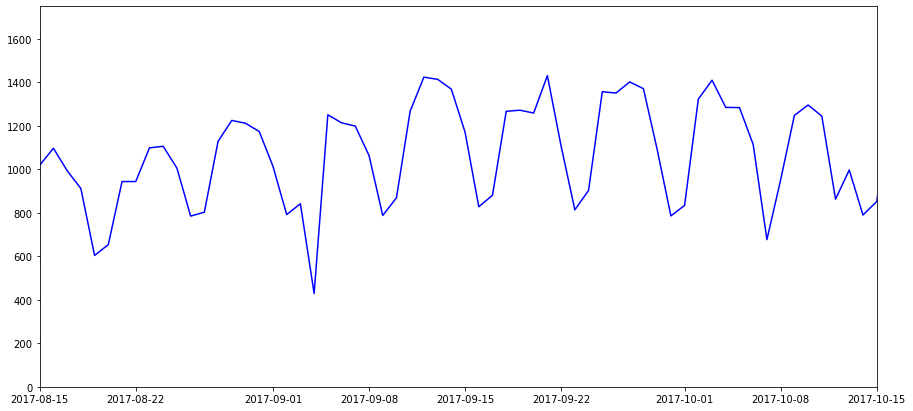

In [31]:
plt.figure(figsize=(15,7))
plt.plot(berkeley_date_dict[571].index, berkeley_date_dict[571].meter_reading_scraped, 'b')
plt.xlim(dt.datetime(2017,8,15), dt.datetime(2017,10,15))
plt.ylim(0, 1750)

### ACF and PACF Plots, Check for Stationarity

In [32]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    plt.figure(figsize=(15,12))
    layout = (3,1)
    raw  = plt.subplot2grid(layout, (0,0))
    acf  = plt.subplot2grid(layout, (1,0))
    pacf = plt.subplot2grid(layout, (2,0))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

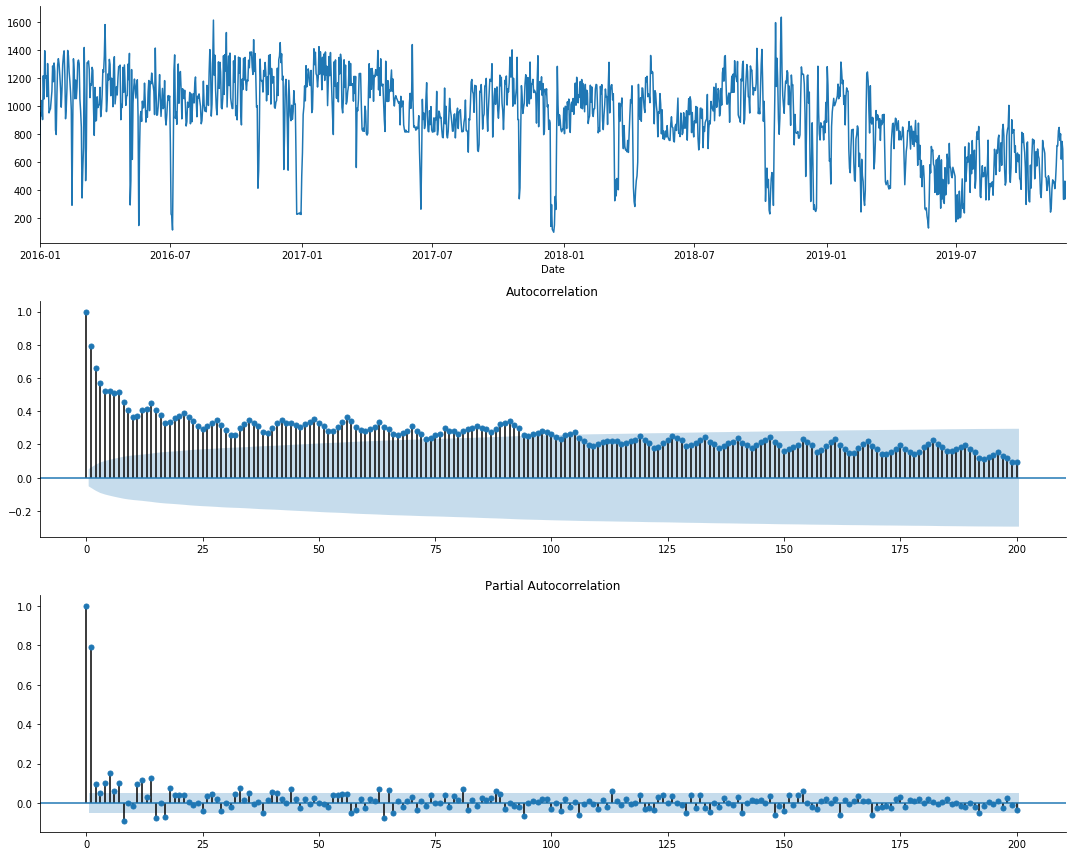

In [124]:
plots(berkeley_date_dict[610].meter_reading_scraped, lags=200);

- Seasonal lags (every 7th lag)
    - 6 significant spikes in PACF (outside confidence interval)
    - 
- Non-seasonal lags
    - 2/3 significant spikes in PACF
        - suggests possible AR(3) term

In [88]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic            -3.561216
p-value                    0.006547
Lags Used                 20.000000
Observations Used       1409.000000
Critical Value (1%)       -3.435000
Critical Value (5%)       -2.863593
Critical Value (10%)      -2.567863
dtype: float64


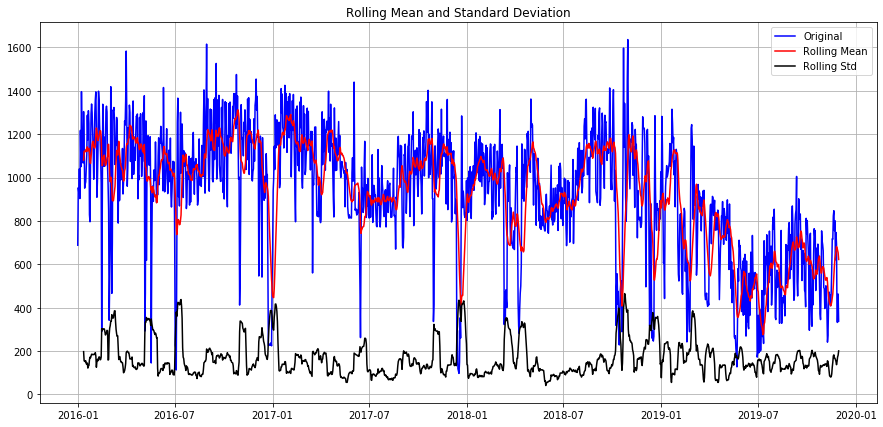

In [128]:
dftest(berkeley_date_dict[610].meter_reading_scraped)

In [127]:
# Daily Data --> d = 1 looks to be the best option
print(np.log(berkeley_date_dict[610].meter_reading_scraped).std())
print(np.log(berkeley_date_dict[610].meter_reading_scraped).diff().std())
print(np.log(berkeley_date_dict[610].meter_reading_scraped).diff().diff().std())
print(np.log(berkeley_date_dict[610].meter_reading_scraped).diff().diff().diff().std())

0.41630857813559835
0.26529170722178497
0.40684528635849593
0.7130893019359906


## Modeling

order=(7,1,1), seasonal_order=(1,0,1,52) --> AIC -509.365
order=(7,1,2), seasonal_order=(1,1,1,52) --> AIC -517.253
order=(7,0,2), seasonal_order=(1,1,1,52) --> AIC -403.292
order=(7,1,1), seasonal_order=(1,1,1,52) --> AIC -349.996
order=(7,1,2), seasonal_order=(1,1,2,52) --> AIC -521
order=(7,1,1), seasonal_order=(0,1,1,52) --> AIC -352.612
order=(1,1,1), seasonal_order=(1,0,1,52) --> AIC -242.217
order=(2,1,1), seasonal_order=(1,1,1,52) --> AIC -107.935
order=(1,1,0), seasonal_order=(0,1,1,7) ---> AIC -730.807

In [113]:
## fit SARIMA based on helper plots
sar = sm.tsa.statespace.SARIMAX(np.log(berkeley_date_dict[601].meter_reading_scraped), 
                                order=(1,1,0), 
                                seasonal_order=(0,1,1,7)).fit(max_iter = 50, method = 'powell')
sar.summary()

Optimization terminated successfully.
         Current function value: -0.006459
         Iterations: 3
         Function evaluations: 146


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:             meter_reading_scraped   No. Observations:                 1430
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 7)   Log Likelihood                   9.236
Date:                           Mon, 09 Dec 2019   AIC                            -12.472
Time:                                   09:54:58   BIC                              3.307
Sample:                               01-01-2016   HQIC                            -6.578
                                    - 11-30-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1561      0.031     -5.052      0.000      -0.217      -0.096
ma.S.L7       -0.9256      0.009    -98.417      0.000      -0.944      -0.907
sigma2         0.0572      0.002     31.991      0.000       0.054       0.061
===================================================================================
Ljung-Box (Q):                      407.59   Jarque-Bera (JB):                61.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [129]:
# SETUP (using itertools to gridsearch solutions)
import itertools

#set parameter range; feel free to update these!
p = range(1,4)
q = range(1,4)
d = range(1,2)
s_p = range(1,4)
s_q = range(1,4)
s_d = range(1,2)
season = 7

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
# same for seasonal variant
pre_seasonal_pdq = list(itertools.product(s_p, s_d, s_q))

seasonal_pdq = []

for i in pre_seasonal_pdq:
    new_tuple = (i[0], i[1], i[2], season)
    seasonal_pdq.append(new_tuple)

In [38]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(np.log(berkeley_date_dict[601].meter_reading_scraped),
                                            order=param,
                                            seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')

            print('SARIMA{},{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Optimization terminated successfully.
         Current function value: -0.313520
         Iterations: 5
         Function evaluations: 351
SARIMA(1, 1, 1),(1, 1, 1, 7)7 - AIC:-886.6680464191211
Optimization terminated successfully.
         Current function value: -0.312318
         Iterations: 5
         Function evaluations: 414
SARIMA(1, 1, 1),(1, 1, 2, 7)7 - AIC:-881.2284843043363
Optimization terminated successfully.
         Current function value: -0.314156
         Iterations: 4
         Function evaluations: 366
SARIMA(1, 1, 1),(1, 1, 3, 7)7 - AIC:-884.4864799747863
Optimization terminated successfully.
         Current function value: -0.314016
         Iterations: 6
         Function evaluations: 468
SARIMA(1, 1, 1),(2, 1, 1, 7)7 - AIC:-886.0846978116865
Optimization terminated successfully.
         Current function value: -0.313981
         Iterations: 5
         Function evaluations: 453
SARIMA(1, 1, 1),(2, 1, 2, 7)7 - AIC:-883.9868458066356
Optimization terminated succes

### Plotting

In [114]:
berkeley599_plot = berkeley_date_dict[599]
del berkeley599_plot['Month']
del berkeley599_plot['building_id']

In [460]:
berkeley580_plot = pd.DataFrame(berkeley580_date2['meter_reading_scraped'])

In [461]:
berkeley580_plot

,meter_reading_scraped
Date,
2016-01-01,1772.0
2016-01-02,1337.0
2016-01-03,1284.0
2016-01-04,2017.0
2016-01-05,1933.0
...,...
2019-11-26,2460.0
2019-11-27,2060.0
2019-11-28,1749.0


In [115]:
def unlog_pred(model):
    
    log_pred = model.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
    pred_ci = log_pred.conf_int()
    
    log_pred = log_pred.predicted_mean
    
    pred = [math.exp(i) for i in log_pred]
    pred = pd.Series(pred, index = log_pred.index)
    
#     pred_ci.columns = [['lower_meter_reading_scraped', 'upper_meter_reading_scraped']]
    
#     lower_pred_ci = [math.exp(i) for i in pred_ci['lower_meter_reading_scraped'].values]
#     upper_pred_ci = [math.exp(i) for i in pred_ci['upper_meter_reading_scraped'].values]
    
#     pred_ci['lower_meter_reading_scraped'] = lower_pred_ci
#     pred_ci['upper_meter_reading_scraped'] = upper_pred_ci
    
    return pred, pred_ci

In [116]:
sar_pred, sar_pred_ci = unlog_pred(sar)

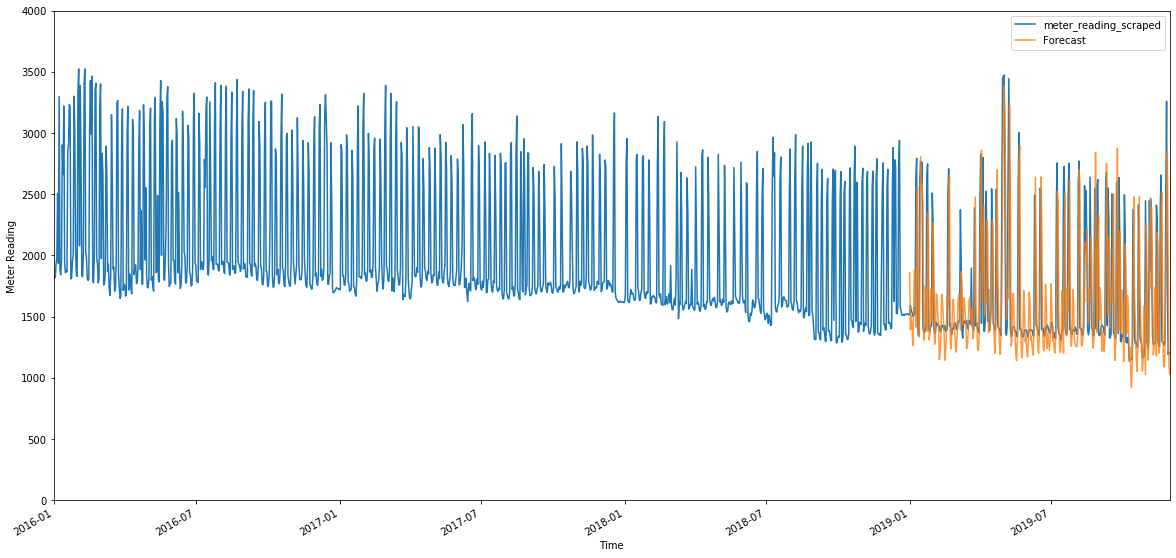

In [120]:
# plot predictions

ax = berkeley599_plot.plot(label='Observed Meter Readings', figsize=(20,10))
sar_pred.plot(ax=ax, label='Forecast', alpha=.8) # this is using all available info

# ax.fill_between(sar_pred_ci.index, sar_pred_ci.iloc[:, 0], sar_pred_ci.iloc[:, 1], color='k', alpha=.1)

# ax.set_xlim(dt.date(2019, 1, 1), dt.date(2019, 11, 30))
ax.set_ylim(0, 4000)
ax.set_xlabel('Time')
ax.set_ylabel('Meter Reading')
plt.legend()

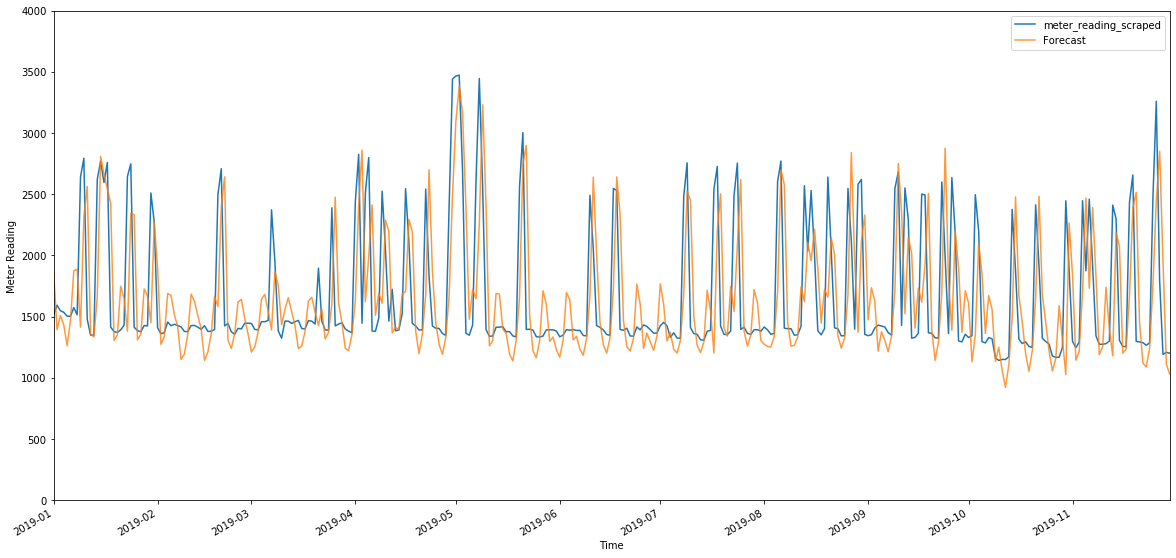

In [121]:
# plot predictions

ax = berkeley599_plot.plot(label='Observed Meter Readings', figsize=(20,10))
sar_pred.plot(ax=ax, label='Forecast', alpha=.8) # this is using all available info

# ax.fill_between(sar_pred_ci.index, sar_pred_ci.iloc[:, 0], sar_pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlim(dt.date(2019, 1, 1), dt.date(2019, 11, 30))
ax.set_ylim(0, 4000)
ax.set_xlabel('Time')
ax.set_ylabel('Meter Reading')
plt.legend()

### Evaluation

In [464]:
# compute mean square error
fcast = sar_pred.values
true = berkeley580_plot[dt.date(2019, 1, 1):]['meter_reading_scraped'].values

mse_score = ((fcast - true) ** 2).mean()
print('MSE of our forecasts is {}'.format(round(mse_score, 3)))

MSE of our forecasts is 577314.963


In [465]:
rmse = math.sqrt(mse_score)
rmse

759.8124523395552

In [466]:
rmse/true.mean()

0.3159810781437026

In [467]:
from sklearn.metrics import mean_absolute_error

In [468]:
mae = mean_absolute_error(true, fcast)

In [469]:
mae/true.mean()

0.23970336450595262

In [122]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox')[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]

# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=61.289, p=0.000
Ljung-Box: val=407.586, p=0.000
Heteroskedasticity: val=1.933, p=0.000
Durbin-Watson: d=2.14


## Walk Forward Validation

In [488]:
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

In [490]:
train, test = train_test_split(X, 367)

In [499]:
type(train)

numpy.ndarray

In [491]:
len(test)

1063

In [515]:
# measure the root mean squared error
def measure_rmse(actual, predicted):
    return math.sqrt(((predicted - actual)**2).mean())

In [613]:
1430-1277

153

In [611]:
i_list = [367,549,731,913,1095,1277,1430]

In [758]:
# walk forward validation in a step by step manner
def walk_forward_validation(data, n_test):
    predictions = []
    train, test = train_test_split(data, n_test)
    history = np.concatenate((train,test[:185]), axis=None) #seed history with training data
    i_list = [367,549,731,913,1095,1277]
      # walk forward
    for index, i in enumerate(i_list):
        print('index:', index)
        if index < 5:
            delta = 182
        else:
            delta = 150
        print('delta:', delta)
        print('i:', i)
        j = i - delta
        print('j:', j)
        print('Length of history', len(history))
        print('len(history)-delta:', len(history)-delta)
        # fit model and make forecast for history
        model = sm.tsa.statespace.SARIMAX(pd.Series(history, index = time[:len(history)]), 
                                order=(7,1,1), 
                                seasonal_order=(1,0,1,52)).fit(max_iter = 50, method = 'powell')

        log_pred = model.get_prediction(start=time[len(history)-delta], dynamic=False) # predict 367 to 549
        log_pred = log_pred.predicted_mean
        
        print('Length of log_pred:', len(log_pred))
        print('---------')
        predictions.append(log_pred)
#         predictions.extend(y) #store the forecast
        history = np.concatenate((history, test[j:i]), axis=None) #add it to history for next loop
    # estimate error
#     error = measure_rmse(test, predictions)
#     print(' > %.3f' % error)
    return history, predictions

In [759]:
log_train, log_preds = walk_forward_validation(X, 367)

index: 0
delta: 182
i: 367
j: 185
Length of history 552
len(history)-delta: 370


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.740683
         Iterations: 5
         Function evaluations: 732
Length of log_pred: 182
---------
index: 1
delta: 182
i: 549
j: 367
Length of history 734
len(history)-delta: 552


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.591034
         Iterations: 7
         Function evaluations: 954
Length of log_pred: 182
---------
index: 2
delta: 182
i: 731
j: 549
Length of history 916
len(history)-delta: 734


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.604769
         Iterations: 5
         Function evaluations: 679
Length of log_pred: 182
---------
index: 3
delta: 182
i: 913
j: 731
Length of history 1098
len(history)-delta: 916


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.578704
         Iterations: 3
         Function evaluations: 420
Length of log_pred: 182
---------
index: 4
delta: 182
i: 1095
j: 913
Length of history 1280
len(history)-delta: 1098


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.600314
         Iterations: 5
         Function evaluations: 728
Length of log_pred: 182
---------
index: 5
delta: 150
i: 1277
j: 1127
Length of history 1430
len(history)-delta: 1280


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.609623
         Iterations: 5
         Function evaluations: 710
Length of log_pred: 150
---------


In [760]:
def unlog(list_of_series):
    
    unlog_list = []
    unlog_dict = {}
    
    for enum, series in enumerate(list_of_series):
        unlog_list = []
        for index, values in series.iteritems():
            unlog_list.append(math.exp(values))
            unlog_dict[enum] = unlog_list
        continue
   
    return unlog_dict

In [761]:
preds = unlog(log_preds)
train = [math.exp(i) for i in log_train]

In [762]:
total_preds = []

for i in range(6):
    for num in preds[i]:
        total_preds.append(num)
    

In [763]:
len(time) - len(total_preds)

370

(0, 5000)

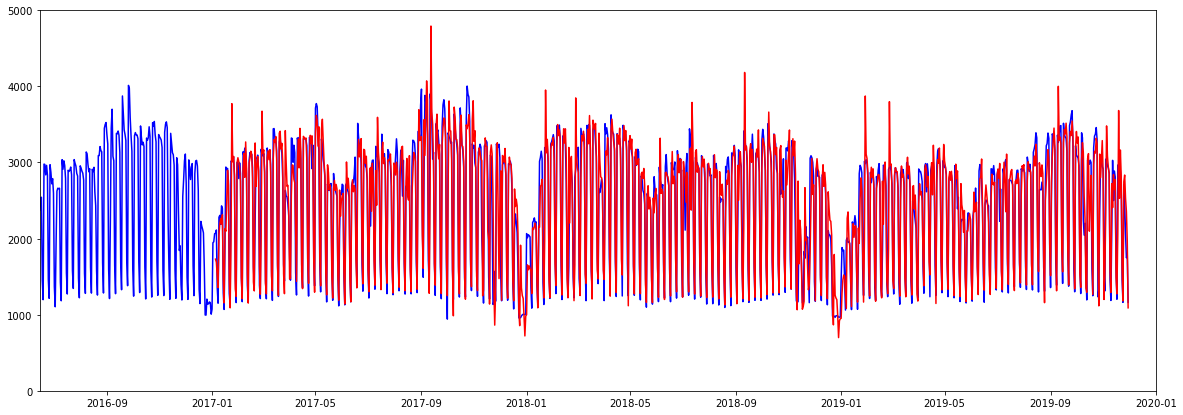

In [766]:
plt.figure(figsize=[20,7])
plt.plot(berkeley580_plot, 'b')
plt.plot(list(time[370:]), total_preds, 'r')
plt.xlim(dt.datetime(2016,6,15), dt.datetime(2020,1,1))
plt.ylim(0, 5000)

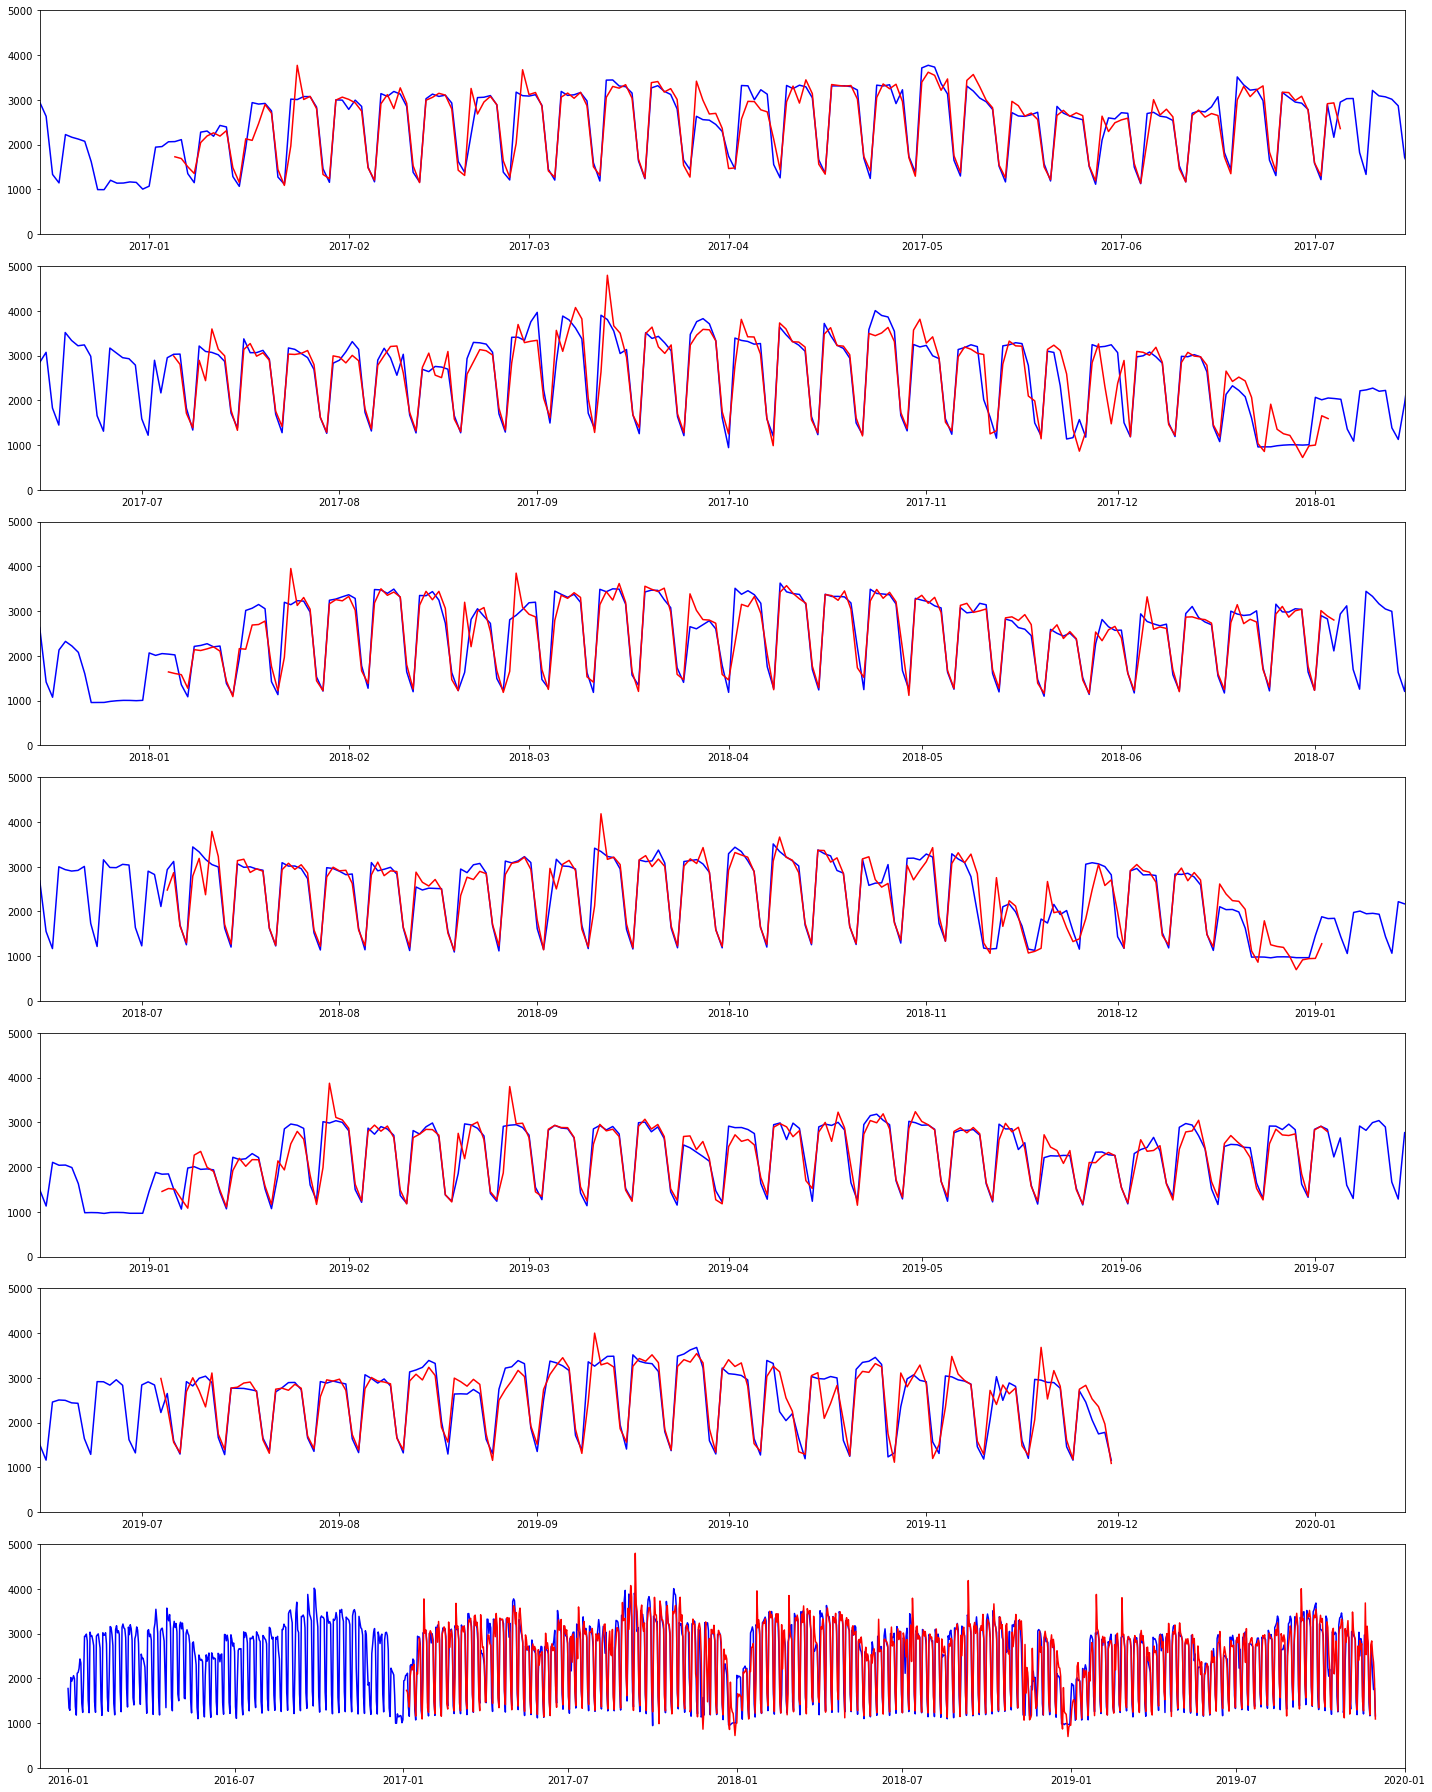

In [768]:
plt.figure(figsize=[20,25])
plt.title('Walk Forward Validation', fontsize=20)

plt.subplot(7,1,1)
plt.plot(berkeley580_plot, 'b')
plt.plot(time[370:552], preds[0], 'r')
plt.xlim(dt.datetime(2016,12,15), dt.datetime(2017,7,15))
plt.ylim(0, 5000)

plt.subplot(7,1,2)
plt.plot(berkeley580_plot, 'b')
plt.plot(time[552:734], preds[1], 'r')
plt.xlim(dt.datetime(2017,6,15), dt.datetime(2018,1,15))
plt.ylim(0, 5000)

plt.subplot(7,1,3)
plt.plot(berkeley580_plot, 'b')
plt.plot(time[734:916], preds[2], 'r')
plt.xlim(dt.datetime(2017,12,15), dt.datetime(2018,7,15))
plt.ylim(0, 5000)

plt.subplot(7,1,4)
plt.plot(berkeley580_plot, 'b')
plt.plot(time[916:1098], preds[3], 'r')
plt.xlim(dt.datetime(2018,6,15), dt.datetime(2019,1,15))
plt.ylim(0, 5000)

plt.subplot(7,1,5)
plt.plot(berkeley580_plot, 'b')
plt.plot(time[1098:1280], preds[4], 'r')
plt.xlim(dt.datetime(2018,12,15), dt.datetime(2019,7,15))
plt.ylim(0, 5000)

plt.subplot(7,1,6)
plt.plot(berkeley580_plot, 'b')
plt.plot(time[1280:1430], preds[5], 'r')
plt.xlim(dt.datetime(2019,6,15), dt.datetime(2020,1,15))
plt.ylim(0, 5000)

plt.subplot(7,1,7)
plt.plot(berkeley580_plot, 'b')
plt.plot(list(time[370:]), total_preds, 'r')
plt.xlim(dt.datetime(2015,12,1), dt.datetime(2020,1,1))
plt.ylim(0, 5000)

plt.tight_layout()

Optimization terminated successfully.
         Current function value: -0.698222
         Iterations: 3
         Function evaluations: 295
For Building 565:
RMSE of our forecasts is 31.271
On average, model has 11.063% error.
Optimization terminated successfully.
         Current function value: -1.402556
         Iterations: 10
         Function evaluations: 893
For Building 567:
RMSE of our forecasts is 241.26
On average, model has 6.072% error.
Optimization terminated successfully.
         Current function value: -0.287217
         Iterations: 5
         Function evaluations: 479
For Building 568:
RMSE of our forecasts is 23.591
On average, model has 14.622% error.
Optimization terminated successfully.
         Current function value: -1.250997
         Iterations: 5
         Function evaluations: 459
For Building 569:
RMSE of our forecasts is 552.412
On average, model has 6.718% error.
Optimization terminated successfully.
         Current function value: -1.166167
         Iterations: 11
         Function evaluations: 1061
For Building 570:
RMSE of our forecasts is 231.456
On average, model has 6.038% error.
Optimization terminated successfully.
         Current function value: -0.323290
         Iterations: 19
         Function evaluations: 1822
For Building 571:
RMSE of our forecasts is 150.503
On average, model has 13.975% error.
Optimization terminated successfully.
         Current function value: -0.989784
         Iterations: 12
         Function evaluations: 1136
For Building 573:
RMSE of our forecasts is 33.657
On average, model has 11.106% error.
Optimization terminated successfully.
         Current function value: -0.184470
         Iterations: 13
         Function evaluations: 1252
For Building 574:
RMSE of our forecasts is 119.616
On average, model has 15.251% error.
Optimization terminated successfully.
         Current function value: -1.036503
         Iterations: 12
         Function evaluations: 1088
For Building 575:
RMSE of our forecasts is 75.583
On average, model has 8.405% error.
Optimization terminated successfully.
         Current function value: -1.562179
         Iterations: 4
         Function evaluations: 375
For Building 576:
RMSE of our forecasts is 321.546
On average, model has 5.776% error.
Optimization terminated successfully.
         Current function value: 0.483541
         Iterations: 6
         Function evaluations: 510
For Building 577:
RMSE of our forecasts is 157.421
On average, model has 10.645% error.
Optimization terminated successfully.
         Current function value: -0.791779
         Iterations: 15
         Function evaluations: 1351
For Building 580:
RMSE of our forecasts is 208.418
On average, model has 8.667% error.
Optimization terminated successfully.
         Current function value: -1.334555
         Iterations: 11
         Function evaluations: 970
For Building 582:
RMSE of our forecasts is 11.392
On average, model has 7.36% error.
Optimization terminated successfully.
         Current function value: -2.223615
         Iterations: 7
         Function evaluations: 663
For Building 583:
RMSE of our forecasts is 108.725
On average, model has 0.933% error.
Optimization terminated successfully.
         Current function value: -0.967370
         Iterations: 6
         Function evaluations: 557
For Building 584:
RMSE of our forecasts is 348.95
On average, model has 9.502% error.
Optimization terminated successfully.
         Current function value: -1.827594
         Iterations: 5
         Function evaluations: 481
For Building 585:
RMSE of our forecasts is 217.915
On average, model has 4.499% error.
Optimization terminated successfully.
         Current function value: -0.315242
         Iterations: 13
         Function evaluations: 1235
For Building 586:
RMSE of our forecasts is 354.95
On average, model has 13.374% error.
Optimization terminated successfully.
         Current function value: -2.248744
         Iterations: 5
         Function evaluations: 480
For Building 587:
RMSE of our forecasts is 69.461
On average, model has 3.069% error.
Optimization terminated successfully.
         Current function value: -0.773110
         Iterations: 3
         Function evaluations: 273
For Building 588:
RMSE of our forecasts is 52.689
On average, model has 10.885% error.
Optimization terminated successfully.
         Current function value: -0.837666
         Iterations: 11
         Function evaluations: 1035
For Building 589:
RMSE of our forecasts is 304.615
On average, model has 9.821% error.
Optimization terminated successfully.
         Current function value: -1.938230
         Iterations: 5
         Function evaluations: 497
For Building 592:
RMSE of our forecasts is 336.56
On average, model has 3.237% error.
Optimization terminated successfully.
         Current function value: -1.973949
         Iterations: 3
         Function evaluations: 289
For Building 594:
RMSE of our forecasts is 227.308
On average, model has 2.536% error.
Optimization terminated successfully.
         Current function value: -0.959193
         Iterations: 11
         Function evaluations: 1046
For Building 595:
RMSE of our forecasts is 453.801
On average, model has 7.598% error.
Optimization terminated successfully.
         Current function value: -0.769912
         Iterations: 21
         Function evaluations: 1870
For Building 597:
RMSE of our forecasts is 468.896
On average, model has 9.088% error.
Optimization terminated successfully.
         Current function value: -1.367258
         Iterations: 3
         Function evaluations: 270
For Building 598:
RMSE of our forecasts is 44.371
On average, model has 4.302% error.
Optimization terminated successfully.
         Current function value: -0.283319
         Iterations: 10
         Function evaluations: 961
For Building 599:
RMSE of our forecasts is 417.204
On average, model has 25.058% error.
Optimization terminated successfully.
         Current function value: -1.445289
         Iterations: 10
         Function evaluations: 916
For Building 600:
RMSE of our forecasts is 93.361
On average, model has 5.774% error.
Optimization terminated successfully.
         Current function value: 0.212962
         Iterations: 7
         Function evaluations: 642
For Building 601:
RMSE of our forecasts is 219.369
On average, model has 52.682% error.
Optimization terminated successfully.
         Current function value: -0.813080
         Iterations: 3
         Function evaluations: 285
For Building 602:
RMSE of our forecasts is 1088.132
On average, model has 11.133% error.

Optimization terminated successfully.
         Current function value: -0.493123
         Iterations: 11
         Function evaluations: 1038
For Building 605:
RMSE of our forecasts is 73.843
On average, model has 15.897% error.
Optimization terminated successfully.
         Current function value: -2.436657
         Iterations: 7
         Function evaluations: 703
For Building 606:
RMSE of our forecasts is 30.231
On average, model has 2.558% error.
Optimization terminated successfully.
         Current function value: -0.945932
         Iterations: 6
         Function evaluations: 548
For Building 607:
RMSE of our forecasts is 49.601
On average, model has 9.131% error.
Optimization terminated successfully.
         Current function value: -1.403122
         Iterations: 3
         Function evaluations: 265
For Building 608:
RMSE of our forecasts is 106.323
On average, model has 6.892% error.
Optimization terminated successfully.
         Current function value: -1.997931
         Iterations: 6
         Function evaluations: 623
For Building 609:
RMSE of our forecasts is 476.594
On average, model has 3.676% error.
Optimization terminated successfully.
         Current function value: 0.000904
         Iterations: 19
         Function evaluations: 1669
For Building 610:
RMSE of our forecasts is 140.575
On average, model has 21.802% error.
Optimization terminated successfully.
         Current function value: -2.260005
         Iterations: 7
         Function evaluations: 665
For Building 611:
RMSE of our forecasts is 300.625
On average, model has 2.606% error.
Optimization terminated successfully.
         Current function value: -2.303046
         Iterations: 5
         Function evaluations: 529
For Building 612:
RMSE of our forecasts is 49.12
On average, model has 2.47% error.
Optimization terminated successfully.
         Current function value: -1.670367
         Iterations: 3
         Function evaluations: 289
For Building 614:
RMSE of our forecasts is 177.571
On average, model has 4.039% error.
Optimization terminated successfully.
         Current function value: -2.086960
         Iterations: 5
         Function evaluations: 492
For Building 615:
RMSE of our forecasts is 630.797
On average, model has 3.393% error.
Optimization terminated successfully.
         Current function value: -1.097388
         Iterations: 2
         Function evaluations: 177
For Building 616:
RMSE of our forecasts is 154.501
On average, model has 7.484% error.
Optimization terminated successfully.
         Current function value: -2.138357
         Iterations: 5
         Function evaluations: 479
For Building 617:
RMSE of our forecasts is 482.412
On average, model has 3.319% error.

Optimization terminated successfully.
         Current function value: 0.096143
         Iterations: 10
         Function evaluations: 968
For Building 619:
RMSE of our forecasts is 240.4
On average, model has 5.618% error.
Optimization terminated successfully.
         Current function value: -1.760746
         Iterations: 6
         Function evaluations: 562
For Building 620:
RMSE of our forecasts is 1323.453
On average, model has 3.92% error.
Optimization terminated successfully.
         Current function value: -0.723785
         Iterations: 4
         Function evaluations: 358
For Building 621:
RMSE of our forecasts is 54.978
On average, model has 13.011% error.
Optimization terminated successfully.
         Current function value: -2.294348
         Iterations: 3
         Function evaluations: 288
For Building 622:
RMSE of our forecasts is 132.851
On average, model has 2.373% error.
Optimization terminated successfully.
         Current function value: -0.906669
         Iterations: 6
         Function evaluations: 579
For Building 623:
RMSE of our forecasts is 48.604
On average, model has 9.568% error.
Optimization terminated successfully.
         Current function value: -1.200998
         Iterations: 3
         Function evaluations: 277
For Building 624:
RMSE of our forecasts is 279.92
On average, model has 8.701% error.
Optimization terminated successfully.
         Current function value: -0.851573
         Iterations: 5
         Function evaluations: 463
For Building 626:
RMSE of our forecasts is 502.751
On average, model has 12.148% error.
Optimization terminated successfully.
         Current function value: -2.000143
         Iterations: 8
         Function evaluations: 761
For Building 627:
RMSE of our forecasts is 101.473
On average, model has 3.639% error.
Optimization terminated successfully.
         Current function value: -1.211373
         Iterations: 4
         Function evaluations: 374
For Building 628:
RMSE of our forecasts is 42.002
On average, model has 7.922% error.
Optimization terminated successfully.
         Current function value: -1.407276
         Iterations: 6
         Function evaluations: 551
For Building 630:
RMSE of our forecasts is 66.26
On average, model has 5.564% error.
Optimization terminated successfully.
         Current function value: -0.852628
         Iterations: 6
         Function evaluations: 558
For Building 631:
RMSE of our forecasts is 27.816
On average, model has 12.087% error.
Optimization terminated successfully.
         Current function value: -1.649103
         Iterations: 9
         Function evaluations: 846
For Building 632:
RMSE of our forecasts is 68.779
On average, model has 5.3% error.
Optimization terminated successfully.
         Current function value: -2.967180
         Iterations: 3
         Function evaluations: 300
For Building 633:
RMSE of our forecasts is 10.475
On average, model has 1.717% error.
Optimization terminated successfully.
         Current function value: -0.171713
         Iterations: 14
         Function evaluations: 1280
For Building 634:
RMSE of our forecasts is 1.275
On average, model has 20.502% error.
Optimization terminated successfully.
         Current function value: -1.111015
         Iterations: 10
         Function evaluations: 934
For Building 635:
RMSE of our forecasts is 9.572
On average, model has 10.415% error.
Optimization terminated successfully.
         Current function value: -0.205646
         Iterations: 7
         Function evaluations: 641
For Building 636:
RMSE of our forecasts is 0.874
On average, model has 21.485% error.
Optimization terminated successfully.
         Current function value: -0.446597
         Iterations: 12
         Function evaluations: 1100
For Building 637:
RMSE of our forecasts is 0.084
On average, model has 9.87% error.
Optimization terminated successfully.
         Current function value: -0.629563
         Iterations: 7
         Function evaluations: 660
For Building 638:
RMSE of our forecasts is 8.68
On average, model has 12.487% error.
Optimization terminated successfully.
         Current function value: -1.498809
         Iterations: 12
         Function evaluations: 1121
For Building 640:
RMSE of our forecasts is 400.585
On average, model has 6.326% error.
Optimization terminated successfully.
         Current function value: -1.737177
         Iterations: 6
         Function evaluations: 587
For Building 641:
RMSE of our forecasts is 461.079
On average, model has 4.509% error.
Optimization terminated successfully.
         Current function value: -0.710994
         Iterations: 3
         Function evaluations: 281
For Building 642:
RMSE of our forecasts is 35.489
On average, model has 12.522% error.
Optimization terminated successfully.
         Current function value: -1.335823
         Iterations: 5
         Function evaluations: 510
For Building 643:
RMSE of our forecasts is 120.89
On average, model has 5.624% error.
Optimization terminated successfully.
         Current function value: -0.714313
         Iterations: 7
         Function evaluations: 659
For Building 644:
RMSE of our forecasts is 1021.479
On average, model has 14.536% error.
Optimization terminated successfully.
         Current function value: -1.676979
         Iterations: 5
         Function evaluations: 458
For Building 645:
RMSE of our forecasts is 1557.337
On average, model has 4.248% error.
Optimization terminated successfully.
         Current function value: -0.661364
         Iterations: 3
         Function evaluations: 261
For Building 646:
RMSE of our forecasts is 122.972
On average, model has 11.351% error.
Optimization terminated successfully.
         Current function value: -1.412104
         Iterations: 6
         Function evaluations: 555
For Building 649:
RMSE of our forecasts is 660.024
On average, model has 7.56% error.
Optimization terminated successfully.
         Current function value: -0.666621
         Iterations: 12
         Function evaluations: 1094
For Building 652:
RMSE of our forecasts is 346.018
On average, model has 11.725% error.
Optimization terminated successfully.
         Current function value: -1.732498
         Iterations: 6
         Function evaluations: 557
For Building 653:
RMSE of our forecasts is 870.969
On average, model has 4.877% error.
Optimization terminated successfully.
         Current function value: -2.177747
         Iterations: 3
         Function evaluations: 281
For Building 654:
RMSE of our forecasts is 25.411
On average, model has 2.074% error.
Optimization terminated successfully.
         Current function value: -0.818837
         Iterations: 9
         Function evaluations: 848
For Building 655:
RMSE of our forecasts is 291.005
On average, model has 9.008% error.